In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d, correlate
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, img_as_ubyte, util, color
from skimage.metrics import peak_signal_noise_ratio

plt.style.use('dark_background')

In [2]:
# Scipy's version
def wiener(im, mysize=None, noise=None):
    """
    Perform a Wiener filter on an N-dimensional array.

    Apply a Wiener filter to the N-dimensional array `im`.

    Parameters
    ----------
    im : ndarray
        An N-dimensional array.
    mysize : int or array_like, optional
        A scalar or an N-length list giving the size of the Wiener filter
        window in each dimension.  Elements of mysize should be odd.
        If mysize is a scalar, then this scalar is used as the size
        in each dimension.
    noise : float, optional
        The noise-power to use. If None, then noise is estimated as the
        average of the local variance of the input.

    Returns
    -------
    out : ndarray
        Wiener filtered result with the same shape as `im`.

    Notes
    -----
    This implementation is similar to wiener2 in Matlab/Octave.
    For more details see [1]_
    """
    
    im = np.asarray(im)
    if mysize is None:
        mysize = [3] * im.ndim
    mysize = np.asarray(mysize)
    if mysize.shape == ():
        mysize = np.repeat(mysize.item(), im.ndim)

    # Estimate the local mean
    lMean = correlate(im, np.ones(mysize), 'same') / np.prod(mysize, axis=0)

    # Estimate the local variance
    lVar = (correlate(im ** 2, np.ones(mysize), 'same') /
            np.prod(mysize, axis=0) - lMean ** 2)

    # Estimate the noise power if needed.
    if noise is None:
        noise = np.mean(np.ravel(lVar), axis=0)

    res = (im - lMean)
    res *= (1 - noise / lVar)
    res += lMean
    out = np.where(lVar < noise, lMean, res)

    return out

In [3]:
# Le-Anh Tran's version
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    gauss = gauss / np.max(np.abs(gauss))
    noisy_img = img + gauss
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'same')
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def tran_wiener(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [4]:
# Our version
def wien(image, No=0.01):
    xdim, ydim = image.shape

    # Create LSI degradation model, need it to be phaseless
    hi = 3.5**(-2)
    h = np.zeros((xdim, ydim))
    xl = 4
    xh = xdim - xl + 2
    h[0:xl, 0:xl] = hi
    h[xh:xdim, 0:xl] = hi
    h[0:xl, xh:ydim] = hi
    h[xh:xdim, xh:ydim] = hi

    # Calculate power spectral density of input image
    PICT = fft2(image)
    Suu = np.abs(PICT)**2

    # Calculate power spectral density of the noise (assuming Gaussian noise with variance No)
    Snn = No * np.ones((xdim, ydim))

    # Calculate Fourier Transform of LSI Filter
    H = fft2(h, (xdim, ydim))
    H2 = np.abs(H)**2

    # Calculate thresholded 1/H
    HINV = np.copy(H)
    index = np.where(np.abs(H) < 0.2)
    hzeros = len(index[0])  # Return number of elements below threshold
    HINV[index] = 0

    # Calculate Wiener Filter
    G = HINV * (H2 * Suu) / ((H2 * Suu) + Snn)

    # Restore Image
    DPICT = fft2(image)
    RPICT = DPICT * G
    rpict = np.abs(ifft2(RPICT))
    
    # Normalize image to the range [-1, 1]
    max_val = np.max(rpict)
    min_val = np.min(rpict)
    rpict = (rpict - min_val) / (max_val - min_val) * 2 - 1

    return rpict

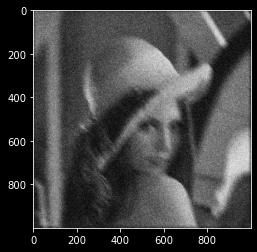

In [16]:
# Load greyscale image
original_image = io.imread('data/lena.jpg')
original_image = color.rgb2gray(original_image)

# Blur it and add noise
blurred_img = blur(original_image, kernel_size=27)
sigma = 30
noisy_image = add_gaussian_noise(blurred_img, sigma=sigma)
# noisy_image = util.random_noise(original_image, mode='gaussian', var=0.3, mean=-0.3)

plt.imshow(noisy_image, cmap='gray')

In [17]:
scipy_image = wiener(noisy_image, mysize=3, noise=1.0)
tran_image = tran_wiener(noisy_image, gaussian_kernel(5), K=10)
our_image = wien(noisy_image, sigma**2)

/tmp/ipykernel_31647/3665322626.py:51: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/tmp/ipykernel_31647/3665322626.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


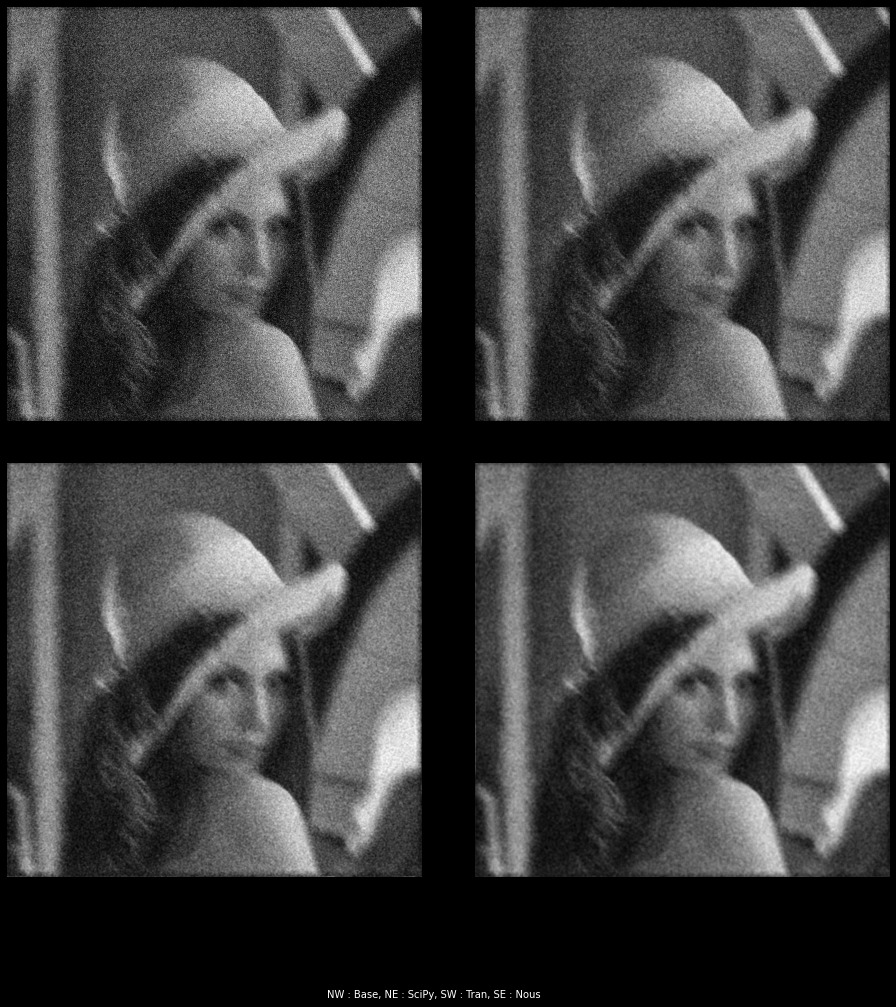

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Affichage de chaque image dans un sous-graphique
axs[0, 0].imshow(noisy_image, cmap='gray')
axs[0, 1].imshow(scipy_image, cmap='gray')
axs[1, 0].imshow(tran_image, cmap='gray')
axs[1, 1].imshow(our_image, cmap='gray')

# Supprimer les axes pour une meilleure apparence
for ax in axs.flatten():
    ax.axis('off')

fig.text(0.5, 0.02, 'NW : Base, NE : SciPy, SW : Tran, SE : Nous', ha='center', fontsize='medium')
# Affichage de la figure
plt.show()

In [19]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
tran_image = img_as_ubyte(tran_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image)

print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from Tran:", psnr_value_tran)
print("PSNR from us:", psnr_value_our)

PSNR from SciPy: 21.20377004487896
PSNR from Tran: 9.165367751429612
PSNR from us: 10.461769915573171
